# Modeling

### Imports

In [1]:
import pandas as pd
from nltk.corpus import stopwords
import string
import re
from nltk.tokenize.regexp import regexp_tokenize

import matplotlib.pyplot as plt

In [ ]:
#data
emails = pd.read_csv('email_df.csv', index_col=0)

In [4]:
stop_words = stopwords.words('english') #stopwords
t = str.maketrans(' ',' ', '!"#$%&–\'.()*+,-/:;<=>?@[\]^_`{|}~') #translation table for preprocessing

In [5]:
#clean emails for modeling. Chose this method to retuce o() complexity. Reduced runtime from 40 min using tokenizers to 6 min.

emails['clean'] = emails['text'].apply(lambda x: str(x).lower().replace("\n", " ").translate(t)) #remove line breaks, remove punctuation
emails['clean'] = emails['clean'].apply(lambda x: ' '.join([word for word in regexp_tokenize(x, pattern='\w+') if word not in stop_words])) #tokenize, remove stopwords

In [11]:
emails.drop(columns=['tokens'], inplace=True)

In [12]:
emails.to_csv('emails_clean.csv', header=emails.columns, index=True)

In [2]:
emails = pd.read_csv('emails_clean.csv', index_col=0)

# Train, Test, Split

In [37]:
from sklearn.model_selection import train_test_split

X = emails['clean'].astype(str)
y = emails['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.35, stratify=y)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, random_state=42, test_size = 0.2, stratify=y_test)

print('Sizes: ')
print('X_train: ', {X_train.shape})
print('X_test: ', {X_test.shape})
print('X_val: ', {X_val.shape})

Sizes: 
X_train:  {(205725,)}
X_test:  {(88620,)}
X_val:  {(22156,)}


## Baseline Model
The target is imbalanced. Given this, if I was to guess each email was from the majority target, what would the accuracy be? 

In [5]:
y_train.value_counts(normalize=True)

Liberal         0.782545
Conservative    0.211107
Center          0.006348
Name: target, dtype: float64

Guessing 'liberal' everytime would result in being accurate 78% of the time. 

## Multi-class Target Baseline
Using a vectorizer, modeling with Naive Bayes, what are the model results without tuning any parameters. 

In [6]:
from sklearn.feature_extraction.text import CountVectorizer

ctv = CountVectorizer() #max_df=0.98, min_df = 0.02

ctv.fit(X_train)

X_train_vectorized = ctv.transform(X_train)
X_test_vectorized = ctv.transform(X_test)

from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf.fit(X_train_vectorized, y_train)

clf.score(X_test_vectorized, y_test)



0.9529225908372828

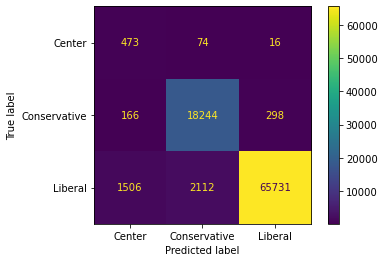

In [63]:
plot_confusion_matrix(clf, X_test_vectorized, y_test)

# Modeling
Modeling with binary target of 'Liberal' vs. 'Conservative.' Emails labled 'Center' makeup less than one percent of the target overall. 

In [23]:
emails2 = emails[emails['target'] != 'Center'].copy()

X = emails2['clean'].astype(str)
y = emails2['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.35, stratify=y)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, random_state=42, test_size = 0.2, stratify=y_test)

print('Sizes: ')
print('X_train: ', {X_train.shape})
print('X_test: ', {X_test.shape})
print('X_val: ', {X_val.shape})

Sizes: 
X_train:  {(204419,)}
X_test:  {(88057,)}
X_val:  {(22015,)}


## Binary Baseline
Establing a binary target continues to produce a similar baseline as before. The accuracy score would be ~79% by guessing the majority target, 'Liberal'.

In [111]:
y_train.value_counts(normalize=True)

Liberal         0.787544
Conservative    0.212456
Name: target, dtype: float64

## Evaluation Functions

In [6]:
#imports for evaluation functions
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, \
                            cohen_kappa_score, auc, roc_auc_score, roc_curve, plot_confusion_matrix, plot_roc_curve

In [7]:
def model_evaluation(model, X_tr, y_tr, X_te, y_te): 
    '''
    Evaluates model and returns accuracy, precision, recall, F1, roc-auc scores, 
    plots a confusion matrix and ROC-AUC graph.
    
    Inputs: 
    model: model fitted to X_tr
    X_tr: Training variable
    y_tr: Training target
    X_te: Test variable
    y_te: Test target
    '''

    #metrics
    avg_cros_val = cross_val_score(model, X_tr, y_tr, cv=3).mean()
    accuracy = accuracy_score(y_te, model.predict(X_te))
    precision = precision_score(y_te, model.predict(X_te), pos_label='Liberal')
    recall = recall_score(y_te, model.predict(X_te), pos_label='Liberal')
    f1 = f1_score(y_te, model.predict(X_te), pos_label='Liberal')
    cohen_kappa = cohen_kappa_score(y_te, model.predict(X_te))
    #rocauc = roc_auc_score(y_te, model.predict(X_te))

    #score_df = score_tracker([avg_cros_val,accuracy,precision,recall,f1, cohen_kappa], model, score_df, id)
    print(f'Average_cross_val: {avg_cros_val}, Accuracy: {accuracy}, Preciaion: {precision}, Recall: {recall}, F1: {f1}, Cohen-Kappa: {cohen_kappa}')
    #plot confusion matrix
    plot_confusion_matrix(model, X_te, y_te)

# Modeling 

## Naive Bayes

In [118]:
from sklearn.feature_extraction.text import CountVectorizer

ctv = CountVectorizer(max_df=0.98, min_df = 0.02)

ctv.fit(X_train)

X_train_vectorized = ctv.transform(X_train)
X_test_vectorized = ctv.transform(X_test)

from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf.fit(X_train_vectorized, y_train)

clf.score(X_test_vectorized, y_test)


0.8971915918098504

Average_cross_val: 0.8969958806830687, Accuracy: 0.8971915918098504, Preciaion: 0.9886857291058808, Recall: 0.8795224156080117, F1: 0.9309147518715517, Cohen-Kappa: 0.732715980043108


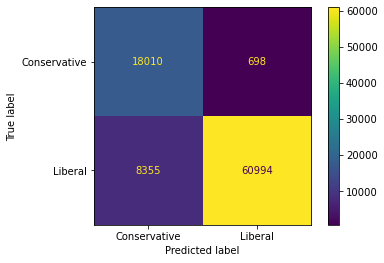

In [168]:
model_evaluation(clf, X_train_vectorized, y_train, X_test_vectorized, y_test)

## Decision Trees

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [170]:
ctv = CountVectorizer(max_df=0.98, min_df = 0.02)

ctv.fit(X_train)

X_train_vectorized = ctv.transform(X_train)
X_test_vectorized = ctv.transform(X_test)

tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train_vectorized, y_train)

tree_cv = cross_val_score(tree, X_train_vectorized, y_train, cv=3)
print(tree_cv.mean())

0.9666273720290955


In [171]:
tree.classes_

array(['Conservative', 'Liberal'], dtype=object)

In [172]:
tree.feature_importances_

array([2.01907925e-04, 2.42654502e-05, 0.00000000e+00, ...,
       1.93085854e-04, 5.60431509e-04, 9.15458269e-05])

Average_cross_val: 0.9666273720290955, Accuracy: 0.971007415651226, Preciaion: 0.9815444950689198, Recall: 0.9816435709238778, F1: 0.9815940304963773, Cohen-Kappa: 0.913348421969317


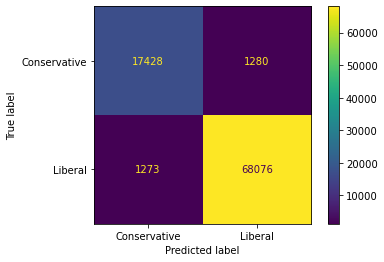

In [174]:
model_evaluation(tree, X_train_vectorized, y_train, X_test_vectorized, y_test)

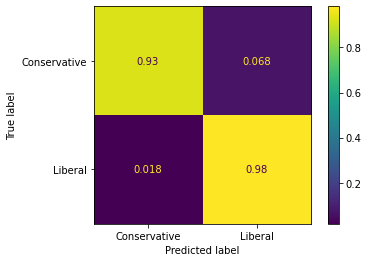

In [175]:
plot_confusion_matrix(tree, X_test_vectorized, y_test, normalize='true')

(https://towardsdatascience.com/how-to-get-feature-importances-from-any-sklearn-pipeline-167a19f1214)

In [180]:
feature_names = ctv.get_feature_names()

feature_importances = tree.feature_importances_

feature_df = pd.DataFrame(zip(feature_names, feature_importances), columns =['feature', 'value'])
feature_df.sort_values(by='value', ascending=False)[:20]


feature     value
273   conservative  0.232549
911        privacy  0.178676
465          fewer  0.071072
693        liberal  0.060692
62         actblue  0.045840
949        radical  0.030853
713         longer  0.020758
344     democratic  0.017877
999     republican  0.017530
1236   unsubscribe  0.010530
617            inc  0.009060
277        contact  0.008594
564         health  0.007519
848           paid  0.006804
845            pac  0.006759
908      president  0.005601
499        freedom  0.005501
540     grassroots  0.005275
966       received  0.004864
913        profile  0.004430

## NN

In [182]:
from tensorflow import keras
from tensorflow.keras import layers

In [185]:
max_length = max([len(s.split()) for s in X_train])

In [210]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc= le.transform(y_test)

In [188]:
tokenizer = keras.preprocessing.text.Tokenizer()

tokenizer.fit_on_texts(X_train)

X_train_token = tokenizer.texts_to_sequences(X_train)
X_test_token = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1

X_train_processed = keras.preprocessing.sequence.pad_sequences(
    X_train_token, maxlen=max_length, padding='post')
X_test_processed = keras.preprocessing.sequence.pad_sequences(
    X_test_token, maxlen=max_length, padding='post')

In [205]:
import numpy as np

In [206]:
def create_embedding_matrix(glove_filepath, word_index, embedding_dim):
    '''
    Grabs the embeddings just for the words in our vocabulary
    
    Inputs:
    glove_filepath - string, location of the glove text file to use
    word_index - word_index attribute from the keras tokenizer
    embedding_dim - int, number of dimensions to embed, a hyperparameter
    
    Output:
    embedding_matrix - numpy array of embeddings
    '''
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(glove_filepath, encoding = 'utf8') as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

    
embedding_dim = 50
embedding_matrix = create_embedding_matrix('glove.6B.50d.txt',
                                           tokenizer.word_index, 
                                           embedding_dim)

In [207]:
# Time to model!
model = keras.models.Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=max_length, 
                           trainable=False)) # Note - not retraining the embedding layer
model.add(layers.Flatten()) # flattening these layers down before connecting to dense layer
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 5175, 50)          6557300   
_________________________________________________________________
flatten_2 (Flatten)          (None, 258750)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 258751    
Total params: 6,816,051
Trainable params: 258,751
Non-trainable params: 6,557,300
_________________________________________________________________


In [208]:
# Defining a results visualization function
def visualize_training_results(history):
    '''
    From https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
    
    Input: keras history object (output from trained model)
    '''
    fig, (ax1, ax2) = plt.subplots(2, sharex=True)
    fig.suptitle('Model Results')

    # summarize history for accuracy
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_ylabel('Accuracy')
    ax1.legend(['train', 'test'], loc='upper left')
    # summarize history for loss
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_ylabel('Loss')
    ax2.legend(['train', 'test'], loc='upper left')
    
    plt.xlabel('Epoch')
    plt.show()

Epoch 1/10
2045/2045 [==============================] - 164s 80ms/step - loss: 0.3203 - accuracy: 0.8741 - val_loss: 0.3042 - val_accuracy: 0.8851
Epoch 2/10
2045/2045 [==============================] - 178s 87ms/step - loss: 0.2711 - accuracy: 0.8936 - val_loss: 0.3519 - val_accuracy: 0.8795
Epoch 3/10
2045/2045 [==============================] - 200s 98ms/step - loss: 0.2589 - accuracy: 0.8983 - val_loss: 0.3284 - val_accuracy: 0.8862
Epoch 4/10
2045/2045 [==============================] - 195s 95ms/step - loss: 0.2514 - accuracy: 0.9010 - val_loss: 0.3566 - val_accuracy: 0.8817
Epoch 5/10
2045/2045 [==============================] - 230s 112ms/step - loss: 0.2472 - accuracy: 0.9024 - val_loss: 0.3646 - val_accuracy: 0.8838
Epoch 6/10
2045/2045 [==============================] - 226s 111ms/step - loss: 0.2417 - accuracy: 0.9041 - val_loss: 0.3663 - val_accuracy: 0.8818
Epoch 7/10
2045/2045 [==============================] - 223s 109ms/step - loss: 0.2386 - accuracy: 0.9060 - val_loss

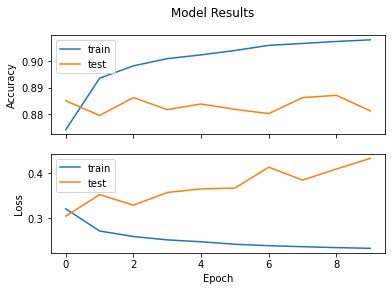

In [211]:
history = model.fit(X_train_processed, y_train_enc,
                    epochs=10,
                    batch_size=100,
                    validation_data=(X_test_processed, y_test_enc))

score = model.evaluate(X_test_processed, y_test_enc, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

# Visualize results
visualize_training_results(history)

## Support Vector Classification

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import SGDClassifier

In [9]:
#instantiate vectorizer
ctv = CountVectorizer(max_df=0.98, min_df = 0.02)

#vectorize
X_train_vectorized = ctv.fit_transform(X_train)
X_test_vectorized = ctv.transform(X_test)

#Instantiate model 
sgdc = SGDClassifier()

#instantiate nystroem
feature_map_nystroem = Nystroem(random_state=42, n_components=700)

#transform with nystroem
X_train_vectorized_transformed = feature_map_nystroem.fit_transform(X_train_vectorized)
X_test_vectorized_transformed = feature_map_nystroem.transform(X_test_vectorized)

#fit to training data
sgdc.fit(X_train_vectorized_transformed, y_train)

#score
sgdc_train = sgdc.score(X_train_vectorized_transformed, y_train)
sgdc_test = sgdc.score(X_test_vectorized_transformed, y_test)

In [10]:
print(sgdc_train, sgdc_test)

0.9441001336735934 0.9438727149627624


Average_cross_val: 0.9446235215919753, Accuracy: 0.9461598737181598, Preciaion: 0.9390681490744013, Recall: 0.99627968680154, F1: 0.9668282921573155, Cohen-Kappa: 0.8246482095168592


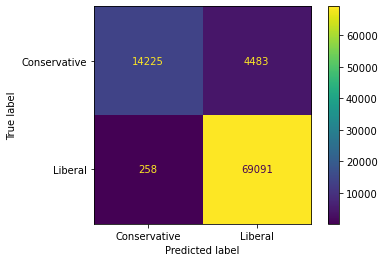

In [218]:
model_evaluation(sgdc, X_train_vectorized_transformed, y_train, X_test_vectorized_transformed, y_test)

In [11]:
sgdc.coef_

array([[-0.04964619,  0.02365905, -0.00547452, ...,  0.01473058,
        -0.00572444, -0.01138402],
       [-0.4721508 ,  0.18500845,  0.86814052, ..., -0.3911817 ,
         0.22821597,  0.38446225],
       [ 0.57881263, -0.23723944, -0.86776039, ...,  0.30635135,
        -0.13986013, -0.37874042]])

In [14]:
#instantiate vectorizer
ctv = CountVectorizer(max_df=0.98, min_df = 0.02)

#vectorize
X_train_vectorized = ctv.fit_transform(X_train)
X_test_vectorized = ctv.transform(X_test)

#Instantiate model 
sgdc = SGDClassifier(class_weight='balanced',
                    random_state=42) 

#instantiate nystroem
feature_map_nystroem = Nystroem(random_state=42, n_components=700)

#transform with nystroem
X_train_vectorized_transformed = feature_map_nystroem.fit_transform(X_train_vectorized)
X_test_vectorized_transformed = feature_map_nystroem.transform(X_test_vectorized)

#fit to training data
sgdc.fit(X_train_vectorized_transformed, y_train)

#score
sgdc_train = sgdc.score(X_train_vectorized_transformed, y_train)
sgdc_test = sgdc.score(X_test_vectorized_transformed, y_test)

In [15]:
print(sgdc_train, sgdc_test)

0.9099817717827197 0.9082599864590386


In [17]:
X_train_vectorized.shape

(205725, 1342)

Keep limits on CountVectorizer, incrase n_components by removing nystroem.

In [24]:
#instantiate vectorizer
ctv = CountVectorizer(max_df=0.98, min_df = 0.02)

#vectorize
X_train_vectorized = ctv.fit_transform(X_train)
X_test_vectorized = ctv.transform(X_test)

#Instantiate model 
sgdc = SGDClassifier(class_weight='balanced',
                    random_state=42) 

#fit to training data
sgdc.fit(X_train_vectorized, y_train)

#score
sgdc_train = sgdc.score(X_train_vectorized, y_train)
sgdc_test = sgdc.score(X_test_vectorized, y_test)

In [25]:
print(sgdc_train, sgdc_test)

0.9678014274602654 0.9646365422396856


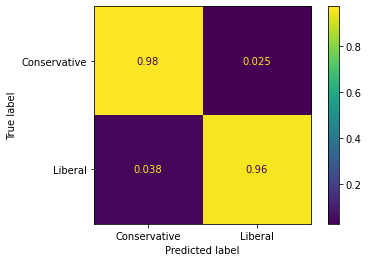

In [26]:
plot_confusion_matrix(sgdc, X_test_vectorized, y_test, normalize='true')

Better! What if everything is untuned except for 'balanced'?

In [ ]:
#instantiate vectorizer
ctv = CountVectorizer()

#vectorize
X_train_vectorized = ctv.fit_transform(X_train)
X_test_vectorized = ctv.transform(X_test)

#Instantiate model 
sgdc = SGDClassifier(class_weight='balanced',
                    random_state=42) 

#fit to training data
sgdc.fit(X_train_vectorized, y_train)

#score
sgdc_train = sgdc.score(X_train_vectorized, y_train)
sgdc_test = sgdc.score(X_test_vectorized, y_test)

Train score: 0.9951570059534584, Test score: 0.9904380117423941


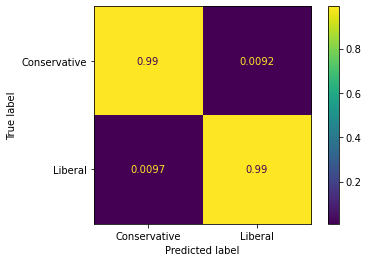

In [31]:
print(f'Train score: {sgdc_train}, Test score: {sgdc_test}')
plot_confusion_matrix(sgdc, X_test_vectorized, y_test, normalize='true');


Panic. Think you're doing something wrong, then try again. 

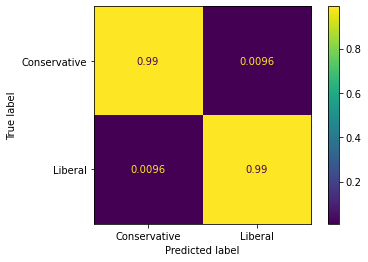

In [35]:
plot_confusion_matrix(sgdc, X_val_vec, y_val, normalize='true');

How well would this work as a multi-class? 

Train score: 0.9945704216794264, Test score: 0.989076957797337


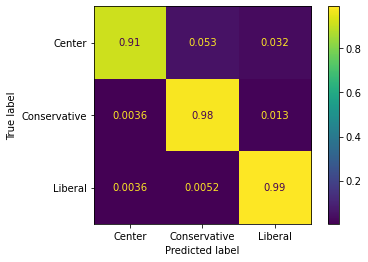

In [38]:
#instantiate vectorizer
ctv = CountVectorizer()

#vectorize
X_train_vectorized = ctv.fit_transform(X_train)
X_test_vectorized = ctv.transform(X_test)

#Instantiate model 
sgdc = SGDClassifier(class_weight='balanced',
                    random_state=42) 

#fit to training data
sgdc.fit(X_train_vectorized, y_train)

#score
sgdc_train = sgdc.score(X_train_vectorized, y_train)
sgdc_test = sgdc.score(X_test_vectorized, y_test)

print(f'Train score: {sgdc_train}, Test score: {sgdc_test}')
plot_confusion_matrix(sgdc, X_test_vectorized, y_test, normalize='true');

NOT POSSIBLE

# LIME
used tutorial: [https://marcotcr.github.io/lime/tutorials/Lime%20-%20basic%20usage%2C%20two%20class%20case.html ](https://marcotcr.github.io/lime/tutorials/Lime%20-%20basic%20usage%2C%20two%20class%20case.html)


In [46]:
#Vectorizer 
vectorizer = CountVectorizer()

train_vectors = vectorizer.fit_transform(X_train)
test_vectors = vectorizer.transform(X_test)

#Model with SGDClassifier
sgdc = SGDClassifier(loss = 'modified_huber',
                     class_weight='balanced',
                     random_state=42)

#fit
sgdc.fit(train_vectors, y_train)

pred = sgdc.predict(test_vectors)
f1_score(y_test, pred, average='weighted')

0.9889052877470594

In [49]:
import lime 
from lime import lime_text
from sklearn.pipeline import make_pipeline

c = make_pipeline(vectorizer, sgdc)

print(c.predict_proba([X_test[73962]]))

[[0. 0. 1.]]


In [85]:
class_names=['Center', 'Conservative', 'Liberal']

from lime.lime_text import LimeTextExplainer
explainer = LimeTextExplainer(class_names=class_names)

idx = 6595
exp = explainer.explain_instance(X_test[idx], c.predict_proba, num_features=10)
print('Document id: %d' % idx)
print('Predicted class =', sgdc.predict(test_vectors[idx]))
print('True class: ', y_test[idx])

Document id: 6595
Predicted class = ['Liberal']
True class:  Liberal


In [86]:
exp.as_list()

[('happyhealer', -0.14418546984693287),
 ('link', -0.13598835486786248),
 ('please', 0.12764215641210244),
 ('click', 0.127590346087451),
 ('unsubscribe', 0.1130331879923841),
 ('president', 0.10493090481490822),
 ('url', 0.09094275460889624),
 ('mailing', -0.08894480255378459),
 ('redacted', -0.08124765539540713),
 ('list', -0.07799449442440926)]

In [87]:
exp.show_in_notebook(text=False)

In [88]:
exp = explainer.explain_instance(X_test[idx], c.predict_proba, num_features=6, top_labels=2)
print(exp.available_labels())

[1, 2]


In [89]:
exp.show_in_notebook(text=False)

In [90]:
exp.show_in_notebook(text=X_test[idx], labels=(1,))